In [38]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Configuración Google Drive
from google.colab import drive
drive.mount('/gdrive')

def read_and_label(folder, label):
    base_path = '/gdrive/MyDrive/TEG-EEG/dataset_bonn/'
    full_path = os.path.join(base_path, folder)
    files = os.listdir(full_path)
    data = []
    for file in files:
        filepath = os.path.join(full_path, file)
        with open(filepath, 'r') as f:
            samples = np.loadtxt(f)
            data.append(samples)
    labels = [label] * len(data)
    return np.array(data), np.array(labels)

# Read and label data
data_ZO, labels_ZO = read_and_label('Z', 0)  # Assuming folder names are 'Z', 'O', etc.
data_O, labels_O = read_and_label('O', 0)
data_NF, labels_NF = read_and_label('N', 1)
data_F, labels_F = read_and_label('F', 1)
data_S, labels_S = read_and_label('S', 2)

# Combine the datasets
all_data = np.concatenate([data_ZO, data_O, data_NF, data_F, data_S])
all_labels = np.concatenate([labels_ZO, labels_O, labels_NF, labels_F, labels_S])

# Normalize the data
mu, sigma = np.mean(all_data), np.std(all_data)
all_data_normalized = (all_data - mu) / sigma

# test normalized data
print(np.mean(all_data_normalized))
print(np.std(all_data_normalized))

# Assuming 'all_data_normalized' contains both signal data and labels
signal_data = all_data_normalized[:, :-1]  # Extract all columns except the last one
labels = all_data_normalized[:, -1]  # Extract only the last column for labels


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
-9.434592342042825e-19
0.9999999999999997


In [39]:

import tensorflow as tf

from keras.utils import to_categorical

def window_data(X, Y, wsize, overlap):
    X_v = []
    Y_v = []

    # Calculate stride based on overlap
    stride = wsize - overlap

    for x, y in zip(X, Y):
        # Window the signal "x" and create corresponding labels
        for start in range(0, len(x) - wsize + 1, stride):
            x_v = x[start:start + wsize]
            X_v.append(x_v)
            Y_v.append(y)  # Repeat the label for each window

    # Convert the lists X_v, Y_v to NumPy arrays
    X_v = np.array(X_v)
    Y_v = np.array(Y_v)

    # Shuffling the data
    #p = np.random.permutation(len(X_v))
    #X_v = X_v[p]
    #Y_v = Y_v[p]

    return X_v, Y_v.flatten()


def split_data(data, labels, num_classes=3):
    # Convert labels to one-hot encoding
    one_hot_labels = to_categorical(labels, num_classes=num_classes)

    # Split the dataset into training, validation, and test sets
    train_data, test_data, train_labels, test_labels = train_test_split(data, one_hot_labels, test_size=0.2, random_state=42, shuffle=True)
    test_data, val_data, test_labels, val_labels = train_test_split(test_data, test_labels, test_size=0.5, random_state=42, shuffle=True)


    # Split the dataset into training, validation, and test sets
    return train_data, val_data, test_data, train_labels, val_labels, test_labels

# Example usage
window_size = 128  # Example value
overlap = 0        # Overlap can be set to zero

windowed_data, windowed_labels = window_data(all_data_normalized, all_labels, window_size, overlap)

print(windowed_data.shape)
print(windowed_labels.shape)

X_train, X_val, X_test, y_train, y_val, y_test = split_data(windowed_data, windowed_labels, num_classes=3)  # Assuming 3 classes

print(X_train.shape)
print(X_val.shape)



(16000, 128)
(16000,)
(12800, 128)
(1600, 128)


In [40]:
# Autoencoder Model
# ---------------------------
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np
import os
import tensorflow as tf

# Building the Denoising Sparse Autoencoder (DSAE)
# -------------------------------------------------
input_size = X_train.shape[1]
hidden_size = 64  # Adjust based on your needs
output_size = input_size

# Encoder
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(hidden_size, activation='relu',
                          activity_regularizer=tf.keras.regularizers.l1(1e-5),
                          name='bottleneck'),
    Dropout(0.05)
])

# Decoder
decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(output_size, activation='linear'),
    Dropout(0.05)
])

# Autoencoder
autoencoder = tf.keras.models.Sequential([encoder, decoder])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

autoencoder.compile( loss='mse',
    optimizer=optimizer)

autoencoder.build((None, input_size))

autoencoder.summary()

# Training the DSAE
# -------------------------------------------------
# Train the autoencoder
history = autoencoder.fit(
    x = X_train,
    y = X_train,
    batch_size=32,
    epochs = 200,
    validation_data = (X_val,X_val),
    verbose=2
)

# Create a separate encoder model for feature extraction
# encoder = Model(inputs=input_layer, outputs=bottleneck)

# Use the encoder to transform data into features for a classifier
# encoded_train = encoder.predict(train_data)
# encoded_test = encoder.predict(test_data)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_18 (Sequential)  (None, 64)                8256      
                                                                 
 sequential_19 (Sequential)  (None, 128)               8320      
                                                                 
Total params: 16576 (64.75 KB)
Trainable params: 16576 (64.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
400/400 - 2s - loss: 1.2833 - val_loss: 0.9260 - 2s/epoch - 4ms/step
Epoch 2/200
400/400 - 1s - loss: 1.0101 - val_loss: 0.7678 - 806ms/epoch - 2ms/step
Epoch 3/200
400/400 - 1s - loss: 0.8535 - val_loss: 0.6550 - 818ms/epoch - 2ms/step
Epoch 4/200
400/400 - 1s - loss: 0.7369 - val_loss: 0.5609 - 819ms/epoch - 2ms/step
Epoch 5/200
400/400 - 1s - loss: 0.6436 - val_loss: 0.4818 - 812ms/epoch - 2ms/s

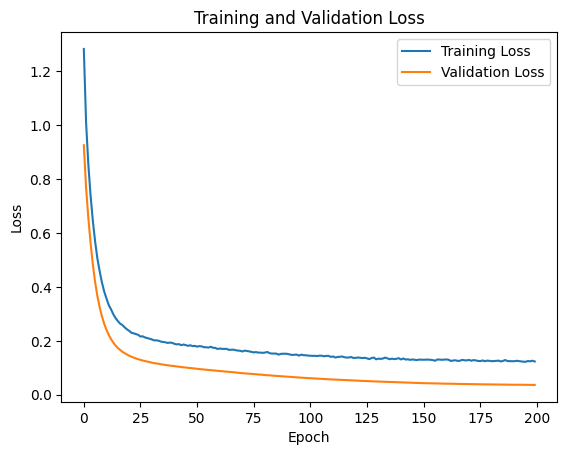

In [41]:

# Plotting
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [42]:
# Assuming 'encoder' is the encoder part of the trained autoencoder
encoded_train = encoder.predict(X_train)
encoded_val = encoder.predict(X_val)
encoded_test = encoder.predict(X_test)

# Now use encoded_train and train_labels to train a classifier
# For example, a simple neural network classifier with Keras
from keras.models import Sequential
from keras.layers import Dense

classifier = Sequential()
classifier.add(Dense(64, activation='relu', input_shape=(encoded_train.shape[1],)))
classifier.add(Dense(3, activation='softmax'))  # Output layer for 3 classes
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the classifier
hist_classifier = classifier.fit(encoded_train, y_train, epochs=50, batch_size=32, validation_data=(encoded_val, y_val))

# Evaluate the classifier
test_loss, test_accuracy = classifier.evaluate(encoded_test, y_test)
print(f"Test accuracy: {test_accuracy}")

50/50 [==============================] - 0s 1ms/step
Epoch 1/50
400/400 [==============================] - 2s 3ms/step - loss: 0.7265 - accuracy: 0.6276 - val_loss: 0.6314 - val_accuracy: 0.6938
Epoch 2/50
400/400 [==============================] - 1s 2ms/step - loss: 0.5684 - accuracy: 0.7507 - val_loss: 0.5274 - val_accuracy: 0.7812
Epoch 3/50
400/400 [==============================] - 1s 2ms/step - loss: 0.4840 - accuracy: 0.8029 - val_loss: 0.4588 - val_accuracy: 0.8294
Epoch 4/50
400/400 [==============================] - 1s 2ms/step - loss: 0.4223 - accuracy: 0.8412 - val_loss: 0.4075 - val_accuracy: 0.8431
Epoch 5/50
400/400 [==============================] - 1s 2ms/step - loss: 0.3788 - accuracy: 0.8580 - val_loss: 0.3869 - val_accuracy: 0.8612
Epoch 6/50
400/400 [==============================] - 1s 2ms/step - loss: 0.3467 - accuracy: 0.8731 - val_loss: 0.3577 - val_accuracy: 0.8687
Epoch 7/50
400/400 [==============================] - 1s 2ms/step - loss: 0.3220 - accuracy: 0.

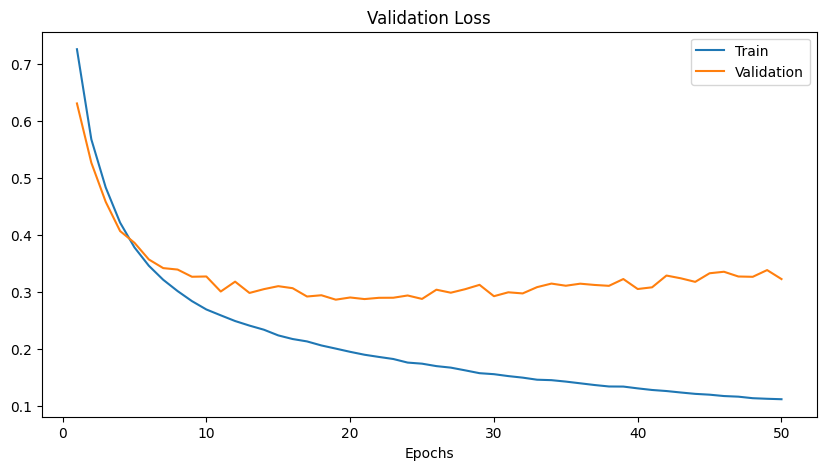

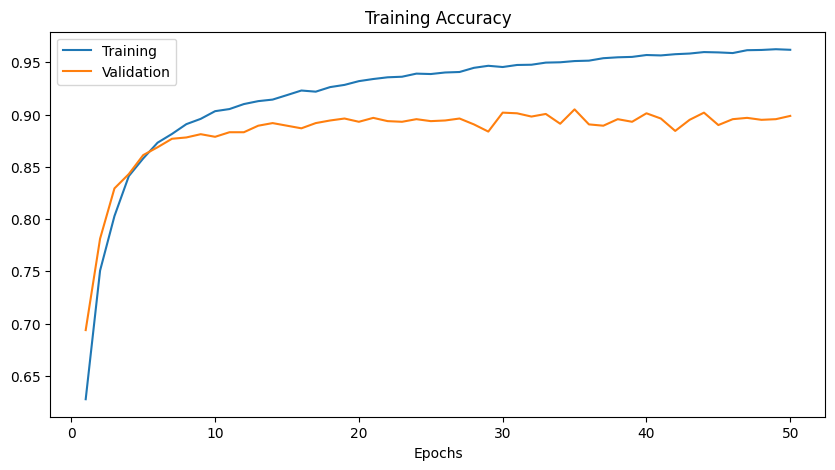

In [43]:
# Plotting validation accuracy and validation loss on the same graph
plt.figure(figsize=(10, 5))
epochs = range(1, len(hist_classifier.history['val_loss']) + 1)

plt.plot(epochs, hist_classifier.history['loss'], label='Train')
plt.plot(epochs, hist_classifier.history['val_loss'], label='Validation')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.legend()

plt.show()

# Plotting training accuracy and training loss on the same graph
plt.figure(figsize=(10, 5))

plt.plot(epochs, hist_classifier.history['accuracy'], label='Training')
plt.plot(epochs, hist_classifier.history['val_accuracy'], label='Validation')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.show()

50/50 [==============================] - 0s 1ms/step


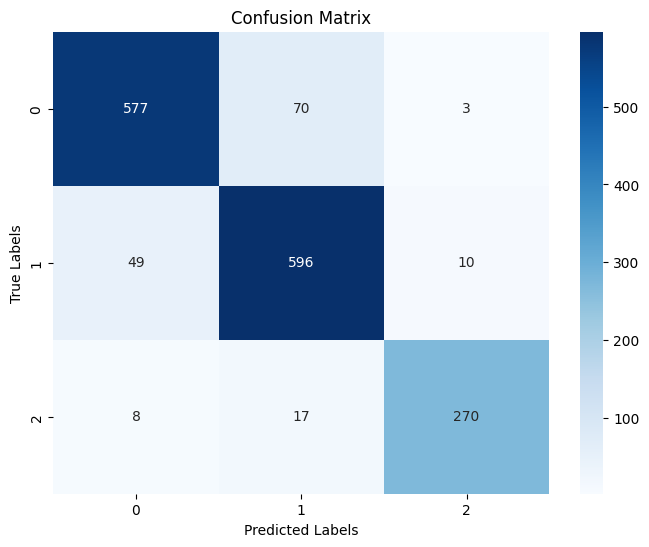

   Class  Sensitivity  Specificity  F1 Score
0      0     0.887692     0.924431  0.898754
1      1     0.909924     0.935660  0.890882
2      2     0.915254     0.981017  0.934256


In [47]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
n_classes = 3

# Get the predictions
y_pred_prob = classifier.predict(encoded_test)

# Calculate sensitivity, specificity, and F1 score
# Function to calculate specificity
def calculate_specificity(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    specificity = []
    for i, label in enumerate(labels):
        true_negatives = np.delete(np.delete(cm, i, axis=0), i, axis=1).sum()
        false_positives = np.delete(cm[i, :], i).sum()
        specificity.append(true_negatives / (true_negatives + false_positives))
    return specificity

# Get the predictions
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate sensitivity, specificity, and F1 score
report = classification_report(y_true, y_pred, output_dict=True)
sensitivity = [report[str(i)]['recall'] for i in range(n_classes)]
f1_scores = [report[str(i)]['f1-score'] for i in range(n_classes)]
specificity = calculate_specificity(y_true, y_pred, labels=[0, 1, 2])

# Plot confusion matrix for each class
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Create a dataframe for sensitivity, specificity, and F1 score
metrics_df = pd.DataFrame({
    'Class': range(n_classes),
    'Sensitivity': sensitivity,
    'Specificity': specificity,
    'F1 Score': f1_scores
})

# Display the dataframe as a table
print(metrics_df)